# Atom mapping using a genetic algorithm

## Importing the Genetic Algorithm Function
First, we import the `genetic_atom_mapping` function from the `main.py` script.

In [2]:
""" print("product")
    print(product_xyz )
    print("educt")
    print(educt_xyz)
    
    target_score = objective([0, 1, 2, 3, 4, 5], educt, educt)
    print("target_score")
    print(target_score)
    real_solution = [1, 2, 3, 0, 4, 5]
    reaL_score = objective(real_solution, product, educt)
    print("real_solution")
    print(real_solution)
    print("reaL_score")
    print(reaL_score)"""

' print("product")\n    print(product_xyz )\n    print("educt")\n    print(educt_xyz)\n    \n    target_score = objective([0, 1, 2, 3, 4, 5], educt, educt)\n    print("target_score")\n    print(target_score)\n    real_solution = [1, 2, 3, 0, 4, 5]\n    reaL_score = objective(real_solution, product, educt)\n    print("real_solution")\n    print(real_solution)\n    print("reaL_score")\n    print(reaL_score)'

In [19]:
from src.pairwise_distance_matrix import pairwise_distance_matrix
from src.GA_util import init_pop, objective, tournament_selection, crossover, gen_reference, mutation, visualize
from src.xyz_parser import XYZ_reader
import pandas as pd
import numpy as np
import itertools


def genetic_atom_mapping(educt_path: str,
                         product_path: str,
                         n_generations: int = 100,
                         pop_size: int = 100,
                         cross_rate: float = 0.9,
                         mut_rate: float = 0.1):
    '''Genetic algorithm for atom mapping of two isomeric structures
    
    Args:
        educt_path: (str) Path to the xyz file of the educt (Default: None)
        product_path: (str) Path to the xyz file of the product (Default: None)
        n_generations: (int) Number of generations (Default: 100)
        pop_size: (int) Population size (Default: 100)
        cross_rate: (float) Crossover rate (Default: 0.9)
        mut_rate: (float) Mutation rate (Default: 0.1)
    Returns:
        best: (list) Best candidate
        best_eval: (float) Best evaluation score
    '''

    product_xyz = XYZ_reader(product_path)
    educt_xyz = XYZ_reader(educt_path)

    # Sort product and educt xyz based on element
    product_xyz = product_xyz.sort_values(by='Element').reset_index(drop=True)
    educt_xyz = educt_xyz.sort_values(by='Element').reset_index(drop=True)
    
    educt = pairwise_distance_matrix(educt_xyz, inverse=True, unit=True, exp=None)
    product = pairwise_distance_matrix(product_xyz, inverse=True, unit=True, exp=None)

    # Get the reference which atoms can get which places
    reference, options = gen_reference(product_xyz)

    # Initialize the population
    pop = [j for i, j in enumerate(init_pop(educt, product, reference,n=5)) if i < (pop_size - 1)]
    
    # Set initial guess
    best, best_eval = pop[0], objective(pop[0], product, educt)
    theoretical_best = objective(list(educt.index), educt, educt)
    print("Initial best f(%s) = %.3f (Theoretical best score = %.3f)" % (pop[0], best_eval, theoretical_best))

   
    for gen in range(n_generations):
        
        # Evaluate all candidates in the population
        scores = [objective(i, product, educt) for i in pop]

        # Check if there's a new best in this generation
        for i in range(len(scores)):
            if scores[i] > best_eval:
                best, best_eval = pop[i], scores[i]
                print(">%d, new best f(%s) = %.3f" % (gen, best, best_eval))
        
        # Select parents in tournament selection
        parents = [tournament_selection(pop, scores) for _ in range(pop_size)]
        
        # Create the next generation    
        children = []
        for i in range(0, pop_size, 2):
            # Get pair of parents
            p1, p2 = parents[i], parents[i + 1]

            for child in [p1,p2]: #crossover(p1, p2, cross_rate):
                child = mutation(child, options, mut_rate)
                children.append(child)

        pop = children

    mapped_educt = educt_xyz.iloc[list(best)].reset_index(drop=True)

    return {"mapping": best, "score": best_eval, "mapped_educt": mapped_educt, 
            "product_xyz": product_xyz, "educt_xyz": educt_xyz}

## Running the Genetic Algorithm
We run the genetic algorithm on two example XYZ files, `educt2.xyz` and `product2.xyz`, with specified parameters.

In [20]:
result1 = genetic_atom_mapping('examples/educt2.xyz','examples/product2.xyz',100,10,0.2,0.1)

Initial best f((0, 2, 3, 1, 5, 4)) = 5.154 (Theoretical best score = 6.000)
>0, new best f((0, 2, 3, 1, 4, 5)) = 5.632
>0, new best f((0, 1, 2, 3, 5, 4)) = 5.668
>1, new best f([0, 3, 2, 1, 5, 4]) = 5.751


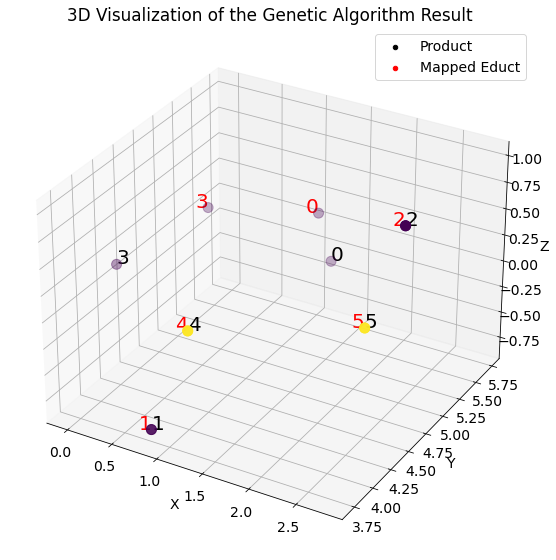

In [21]:
visualize(result1)

## Mapping Similarity Using KD-Tree

We define a function to map the similarity of molecules considering the element type using KD-Tree using KD-Tree from the `scipy.spatial` module.

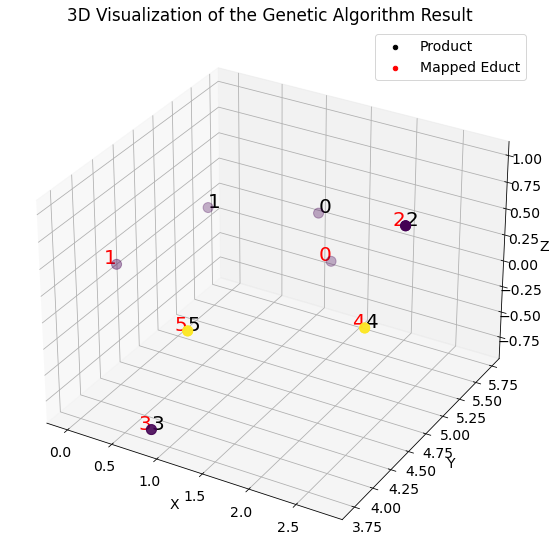

In [ ]:
from scipy.spatial import cKDTree

def map_similarity_molecule_element(file1, file2):
    """Map the atom indices of two molecules

    cKDTree is used to map the atom indices of two molecules based on the element type.
    This works by finding the nearest atom in the product molecule for each atom in the educt molecule.
    The mapping is then enforced to have the same element type.

    Args:
        file1: (str) Path to the xyz file of the first molecule
        file2: (str) Path to the xyz file of the second molecule
    Returns:
        mapping: (tuple) Mapping of the atom indices
        mapped_educt: (DataFrame) Mapped educt molecule
        product_xyz: (DataFrame) Product molecule
        educt_xyz: (DataFrame) Educt molecule
    """

    product_xyz = XYZ_reader(file1)
    educt_xyz = XYZ_reader(file2)

    product_xyz = product_xyz.sort_values(by='Element').reset_index(drop=True)
    educt_xyz = educt_xyz.sort_values(by='Element').reset_index(drop=True)

    tree = cKDTree(product_xyz[['x', 'y', 'z']].values.tolist())
    _, idx = tree.query(educt_xyz[['x', 'y', 'z']].values.tolist())
   
    # Get the mapping, and enforce the element to be the same
    educt_map = [j for i, j in enumerate(idx) if educt_xyz['Element'][i] == product_xyz['Element'][j]]
    product_map = [i for i, j in enumerate(idx) if educt_xyz['Element'][i] == product_xyz['Element'][j]]
    mapping = (educt_map, product_map)

    # Remap educt_xyz based on idx
    mapped_educt = educt_xyz.iloc[mapping[0]].reset_index(drop=True)

    return {"mapping": mapping, "mapped_educt": mapped_educt, "product_xyz": product_xyz, "educt_xyz": educt_xyz}

visualize(map_similarity_molecule_element('examples/educt2.xyz','examples/product2.xyz'))